# GPJM: fMRI Experiment

11/09/2019

Giwon Bahg

Fit the GPJM with three-dimensional latent dynamics. Note that this model does not consider the spatial relationship between regions of interest (ROIs), unlike the simulation study.

## Import packages and data

In [ ]:
import numpy as np
import gpflow
import tensorflow as tf
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
# Time indices
time_block = np.load("time_block.npy")
ts_dense = np.load("ts_dense.npy") # Time indices for behavioral data
ts_sparse = np.load("ts_sparse.npy") # Time indices for neural data

In [ ]:
# Time indices for the fixation onset (i.e., beginning of new trials)
fix_onset = np.array([  0.,  39.,  78., 117., 156., 195., 235., 274., 313., 353., 393., 431., 469., 508., 547., 587., 627., 665., 705., 744.], dtype=np.int)

In [ ]:
# Load the coherence information
# Only the variable 'coh1', which corresponds to the first run of the experiment, is used.
coh = np.zeros((ts_sparse.shape[0], 4))
for block in range(4):
    coh[:,block] = np.load("coherence_scaled_sub13_run"+str(block+1)+".npy")[:,0]

coh0 = coh.T.ravel().reshape(-1,1)
coh1 = np.load("coherence_scaled_013_run1.npy")

# Upscale the coherence
coh1_ext = np.column_stack([coh1, coh1]).ravel()
coh1_ext = coh1_ext[0:(len(coh1_ext)-1)]
coh1 = coh1_ext.reshape(-1,1)

In [ ]:
# Load the mouse trajectory
# Only the variable 'Y_B1' is used.
Y_B = np.zeros((ts_dense.shape[0], 4))
for block in range(4):
    Y_B[:,block] = np.load("mouse_trajectory_centered_scaled_sub13_run"+str(block+1)+".npy")[:,0]

Y_B0 = Y_B.T.ravel().reshape(-1,1)
Y_B1 = np.load("mouse_trajectory_centered_scaled_013_run1.npy")

# Logit-transform the behavioral data
temp = Y_B1/2 + 0.5
temp[np.where(temp == 0)[0]] = 1e-5
Y_B1 = np.log(temp/(1-temp))

# Store the original value separately
Y_B1_org = np.load("mouse_trajectory_centered_scaled_sub13_run1.npy")

In [ ]:
# Load the neural data
Y_N1 = np.load("Timing013_meanTS_block1.npy")
# Y_N2 = np.load("Timing013_meanTS_block2.npy") # Not used
# Y_N3 = np.load("Timing013_meanTS_block3.npy")
# Y_N4 = np.load("Timing013_meanTS_block4.npy")

In [ ]:
# ROI information: Not used for fitting the model.
## Coherence-related regions
ss_RC = np.array([[-54, 23, 0], [32, -23, 64], [29, -69, -41], [-48, 48, -14], [-9, -88, 26], [49, -40, 9], [7, -72, -9]], dtype = np.float64)
## Behavioral-response-related regions
ss_resp = np.array([[66, -3, 22], [54, -14, 6], [-44, -64, 11], [10, -6, 72], [-44, -3, 61], [-52, 0, 32], [60, -25, 13], [-53, -21, 10], [-10, -56, 68]], dtype = np.float64)

ss = np.vstack([ss_RC, ss_resp])

# ROI labels
label_ROI = np.array(['RC1_IFG', 'RC2_PCG', 'RC3_CRUS2', 'RC4_FP', 'RC5_OP', 'RC6_PSG', 'RC7_LG',
            'resp1_SSC1', 'resp2_AC1', 'resp3_V5', 'resp4_PMC(SFG)', 'resp5_PMC(MFG)','resp6_MC1', 'resp7_IPL', 'resp8_AC1', 'resp9_SPL'])

## Set up the model

In [ ]:
# Generate a convolved RBF kernel 
class KernelHRFConvDownsized_RBF(gpflow.kernels.Kernel):
    def __init__(self, input_dim, ts_N, ts_dense, ARDprior):
        super().__init__(input_dim = input_dim)
        # Set the basis kernel
        self.kernel = gpflow.kernels.RBF(input_dim = input_dim, ARD=ARDprior)
        # Set the HRF
        def HRF_filter(ts_dense):
            ts = np.squeeze(ts_dense)
            unit_ts = ts[ts <= 30]
            def HRFunit(t):
                from scipy.special import gamma
                a1 = 6 # b1=1
                a2 = 16 # b2=1
                c = 1./6
                part1 = t**(a1-1) * np.exp(-t) / gamma(a1)
                part2 = t**(a2-1) * np.exp(-t) / gamma(a2)
                return part1 - c * part2
            hrf = HRFunit(unit_ts)
            return(hrf)
        self.hrf_dense = tf.constant(np.flip(HRF_filter(ts_dense)))
        self.len_hrf_dense = self.hrf_dense.shape[0]
        # Set the downsizing scheme
        def downsizing_scheme_nearest(ts_N, ts_dense):
            M = np.zeros((ts_dense.shape[0], ts_N.shape[0]))
            ts = np.squeeze(ts_dense)
            for i in range(ts_N.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_N[i,0]))
                M[argmin_idx,i] = 1
            return M
        self.M = tf.constant(downsizing_scheme_nearest(ts_N, ts_dense))

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            X2=X
        padK = tf.pad(self.kernel.K(X, X2), [[self.len_hrf_dense-1, 0],[self.len_hrf_dense-1,0]], 'CONSTANT')
        hrf4conv = tf.reshape(self.hrf_dense, [self.len_hrf_dense, 1, 1])
        temp0 = tf.reshape(padK, [tf.shape(padK)[0], tf.shape(padK)[1], 1], name='temp0')
        res0 = tf.squeeze(tf.nn.conv1d(temp0, hrf4conv, 1, 'VALID'))
        temp1 = tf.reshape(tf.transpose(res0), [tf.shape(res0)[1], tf.shape(res0)[0], 1], name='temp1')
        res1 = tf.transpose(tf.squeeze(tf.nn.conv1d(temp1, hrf4conv, 1, 'VALID')))
        # Downsample the dense kernel
        res2 = tf.matmul(tf.transpose(self.M), tf.matmul(res1, self.M))
        return(res2)

In [ ]:
class GPJMv2(gpflow.models.Model):
    def __init__(self, Y_N, Y_B, ts_N, ts_B, n_latent, ss, conv_scheme = KernelHRFConvDownsized_RBF,
                 kern_tX = None, mean_tX = None, kern_XN = None, mean_XN = None, kern_XB = None, mean_XB = None, name=None):
        if kern_tX is None:
            kern_tX = gpflow.kernels.RBF(input_dim=1, ARD = True)
        if mean_tX is None:
            mean_tX = gpflow.mean_functions.Zero(output_dim = n_latent)
        if kern_XN is None:
            kern_XN = conv_scheme(input_dim = n_latent, ts_N = ts_N, ts_dense = ts_B, ARDprior=True)
        if mean_XN is None:
            mean_XN = gpflow.mean_functions.Zero(output_dim = Y_N.shape[1])
        if kern_XB is None:
            kern_XB = gpflow.kernels.Matern12(input_dim = n_latent, ARD=True)
        if mean_XB is None:
            mean_XB = gpflow.mean_functions.Zero(output_dim = Y_B.shape[1])
        super().__init__(name=name)
        
        def cubic_interpolation(ts_sparse, Y_N, ts_dense, ss):
            from scipy import interpolate
            yn_new = np.zeros((ts_dense.shape[0], ss.shape[0]))
            yn_array = Y_N.reshape(ss.shape[0], ts_sparse.shape[0]).T
            for i in range(ss.shape[0]):
                temp = interpolate.interp1d(np.squeeze(ts_sparse), yn_array[:,i], kind='cubic')
                yn_new[:,i] = temp(np.squeeze(ts_dense))
            return yn_new
        
        def downsizing_scheme_nearest(ts_sparse, ts_dense):
            M = np.zeros((ts_dense.shape[0], ts_sparse.shape[0]))
            ts = np.squeeze(ts_dense)
            for i in range(ts_sparse.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_sparse[i,0]))
                M[argmin_idx,i] = 1
            return M
        
        def HRF_filter(ts_dense):
            ts = np.squeeze(ts_dense)
            unit_ts = ts[ts <= 30]
            def HRFunit(t):
                from scipy.special import gamma
                a1 = 6 # b1=1
                a2 = 16 # b2=1
                c = 1./6
                part1 = t**(a1-1) * np.exp(-t) / gamma(a1)
                part2 = t**(a2-1) * np.exp(-t) / gamma(a2)
                return part1 - c * part2
            hrf = HRFunit(unit_ts)
            return(hrf)
        
        if len(ts_N) > len(ts_B):
            print("Neural: Dense / Behavioral: Sparse")
            self.ts = tf.constant(ts_N.copy())
        elif len(ts_N) < len(ts_B):
            print("Neural: Sparse / Behavioral: Dense")
            self.ts = tf.constant(ts_B.copy())
            self.ts_dense = ts_B.copy()
            self.Y_N_interp = cubic_interpolation(ts_N, Y_N, ts_B, ss)
            self.M = downsizing_scheme_nearest(ts_N, ts_B)
        
        # Data
        self.Y_N = tf.constant(Y_N.copy())
        self.Y_B = tf.constant(Y_B.copy())
        self.ts_N = tf.constant(ts_N.copy())
        self.ts_B = tf.constant(ts_B.copy())
        self.n_Nsample = Y_N.shape[0]
        self.n_Nfeature = Y_N.shape[1]
        self.n_Bsample = Y_B.shape[0]
        self.n_Bfeature = Y_B.shape[1]
        
        # latent dynamics kernel + downsizing scheme
        self.kern_tX = kern_tX
        self.mean_tX = mean_tX
        self.n_latent = n_latent
        self.N_pca = gpflow.models.gplvm.PCA_reduce(self.Y_N_interp, n_latent)
        self.X = gpflow.Param(gpflow.models.gplvm.PCA_reduce(self.Y_N_interp, n_latent))
        self.X_sparse = gpflow.models.gplvm.PCA_reduce(Y_N, n_latent)

        # Neural data kernel
        self.kern_XN = kern_XN
        self.mean_XN = mean_XN
        self.hrf = tf.constant(HRF_filter(self.ts_dense))
        
        # Behavioral data kernel
        self.kern_XB = kern_XB
        self.mean_XB = mean_XB

        # Likelihood
        self.likelihood_tX = gpflow.likelihoods.Gaussian()
        self.likelihood_XN = gpflow.likelihoods.Gaussian()
        self.likelihood_XB = gpflow.likelihoods.Gaussian() # Can differ according to the model you rely on.
    
    @gpflow.params_as_tensors
    def _build_likelihood_tX(self): # Zero-noise model is not supported by GPflow ==> Need to add an infinitesimal noise when initializing the model.
        Ktx = self.kern_tX.K(self.ts, self.ts) + tf.eye(tf.shape(self.ts)[0], dtype = gpflow.settings.float_type) * self.likelihood_tX.variance
        Ltx = tf.cholesky(Ktx)
        mtx = self.mean_tX(self.ts)
        logpdf_tx = gpflow.logdensities.multivariate_normal(self.X, mtx, Ltx)
        return tf.reduce_sum(logpdf_tx)
    
    @gpflow.params_as_tensors
    def _build_likelihood_XN(self):
        Kxn = self.kern_XN.K(self.X, self.X) + tf.eye(self.n_Nsample, dtype = gpflow.settings.float_type) * self.likelihood_XN.variance
        Lxn = tf.cholesky(Kxn)
        mxn = self.mean_XN(self.X_sparse)
        logpdf_xn = gpflow.logdensities.multivariate_normal(self.Y_N, mxn, Lxn)
        return tf.reduce_sum(logpdf_xn)

    @gpflow.params_as_tensors
    def _build_likelihood_XB(self):
        Kxb = self.kern_XB.K(self.X, self.X) + tf.eye(tf.shape(self.X)[0], dtype = gpflow.settings.float_type) * self.likelihood_XB.variance
        Lxb = tf.cholesky(Kxb)
        mxb = self.mean_XB(self.X)
        logpdf_xb = gpflow.logdensities.multivariate_normal(self.Y_B, mxb, Lxb)
        return tf.reduce_sum(logpdf_xb)
    
    @gpflow.name_scope('likelihood')
    @gpflow.params_as_tensors
    def _build_likelihood(self):
        logpdf_tx = self._build_likelihood_tX()
        logpdf_xn = self._build_likelihood_XN()
        logpdf_xb = self._build_likelihood_XB()
        return tf.reduce_sum(logpdf_tx + logpdf_xn + logpdf_xb)

In [ ]:
# Functions for extractitng the model fitting results
def recover_latent(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    ts = tf.Session().run(m.ts)
    Kstar = m.kern_tX.compute_K(ts, ts_new)
    KttI = m.kern_tX.compute_K(ts, ts) + np.eye(ts.shape[0], dtype=np.float64) * m.likelihood_tX.variance.read_value()
    X = m.X.read_value()
    L = cholesky(KttI)
    return Kstar.T.dot(inv(L.T).dot((inv(L)).dot(X)))

def recover_neural(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    ts_N = tf.Session().run(m.ts_N)
    Y_N = tf.Session().run(m.Y_N)
    X_new = recover_latent(m, ts_new)
    X = m.X.read_value()
    Kstar = m.kern_XN.compute_K(X, X_new)
    KttI = m.kern_XN.compute_K(X, X) + np.eye(Y_N.shape[0], dtype = np.float64) * m.likelihood_XN.variance.read_value()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_N)))
    v = inv(L).dot(Kstar)
    Vstar = Kstar - v.T.dot(v)
    sd = np.sqrt(np.diag(Vstar))
    return fmean, Vstar, sd

def recover_behavioral(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    X = m.X.read_value()
    Kstar = m.kern_XB.compute_K(X, X)
    KttI = m.kern_XB.compute_K(X, X) + np.eye(m.Y_B.shape[0], dtype = np.float64) * m.likelihood_XB.variance.read_value()
    Y_B = tf.Session().run(m.Y_B)
    L = cholesky(KttI)
    
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_B)))
    v = inv(L).dot(Kstar)
    Vstar = m.kern_XB.compute_K(X, X) - v.T.dot(v)
    ci95 = np.column_stack([fmean - 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1), fmean + 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1)])
    return fmean, Vstar, ci95

## Fit the model

In [ ]:
test = GPJMv2(Y_N1, Y_B1, ts_sparse, ts_dense, 3, ss)
test.likelihood_tX.variance = 1e-6
test.likelihood_tX.variance.trainable = False

In [ ]:
# Run for 600 iterations
# Save the results every 20 iterations (for back-up)
max_iter = 600
record_step = 20
X_storage = np.zeros((test.X.value.shape[0], test.X.value.shape[1], (max_iter+1)))
llk_storage = np.zeros(max_iter+1)
learning_rate_vec_temp = 0.2/np.sqrt(np.arange(max_iter)+1)
learning_rate_vec = np.zeros_like(learning_rate_vec_temp)
for i in range(len(learning_rate_vec_temp)):
    learning_rate_vec[i] = learning_rate_vec_temp[int(np.floor(i/record_step))]

saved_at = 0
llk_storage = np.zeros(max_iter+1)
llk_storage[0] = test.compute_log_likelihood()
session = gpflow.get_default_session()

# Fit the model
start_time = time.time()
for iter in range(max_iter):
    if (iter)%record_step==0:
        lr = learning_rate_vec[iter]
        opt = gpflow.train.AdamOptimizer(learning_rate = lr)
        opt_tensor = opt.make_optimize_tensor(test)
    session.run(opt_tensor)
    llk_storage[(iter+1)] = test.compute_log_likelihood()
    if (iter+1)%100 == 0:
        test.anchor(session)
        np.savez('GPJM_3dim_fitted.npz', best_model = test.read_trainables(), llk = llk_storage)
    if (iter+1)%10 == 0:
        print("Iter "+str(iter+1)+" - Learning rate: "+str(np.round(lr, 3))+", LLK: "+str(np.round(llk_storage[(iter+1)], 5)))

# Save the result
test.anchor(session)
np.savez('GPJM_3dim_fitted.npz', best_model = test.read_trainables(), llk = llk_storage)
end_time = time.time()
print(end_time - start_time)

## Filter the latent dynamics (for visual clarity)

In [ ]:
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline, CubicSpline

latent4 = test.X.value # Latent dynamics

l4sg31 = np.zeros_like(latent4)
l4sg51 = np.zeros_like(latent4)
for i in range(latent4.shape[1]):
    l4sg31[:,i] = savgol_filter(latent4[:,i], 31, 3) # Window size = 31
    l4sg51[:,i] = savgol_filter(latent4[:,i], 51, 3) # Window size = 51

## Recovery: Neural Data

In [ ]:
label_ROI = np.array(['Table S3 Row 1', 'Table S3 Row 2', 'Table S3 Row 3', 'Table S3 Row 4', 'Table S3 Row 5', 'Table S3 Row 6', 'Table S3 Row 7',
            'Table S4 Row 1', 'Table S4 Row 2', 'Table S4 Row 3', 'Table S4 Row 4', 'Table S4 Row 5', 'Table S4 Row 6', 'Table S4 Row 7', 'Table S4 Row 8', 'Table S4 Row 9'])

In [ ]:
yhat_arr, yhat_v, yhat_sd = recover_neural(test4, ts_dense)

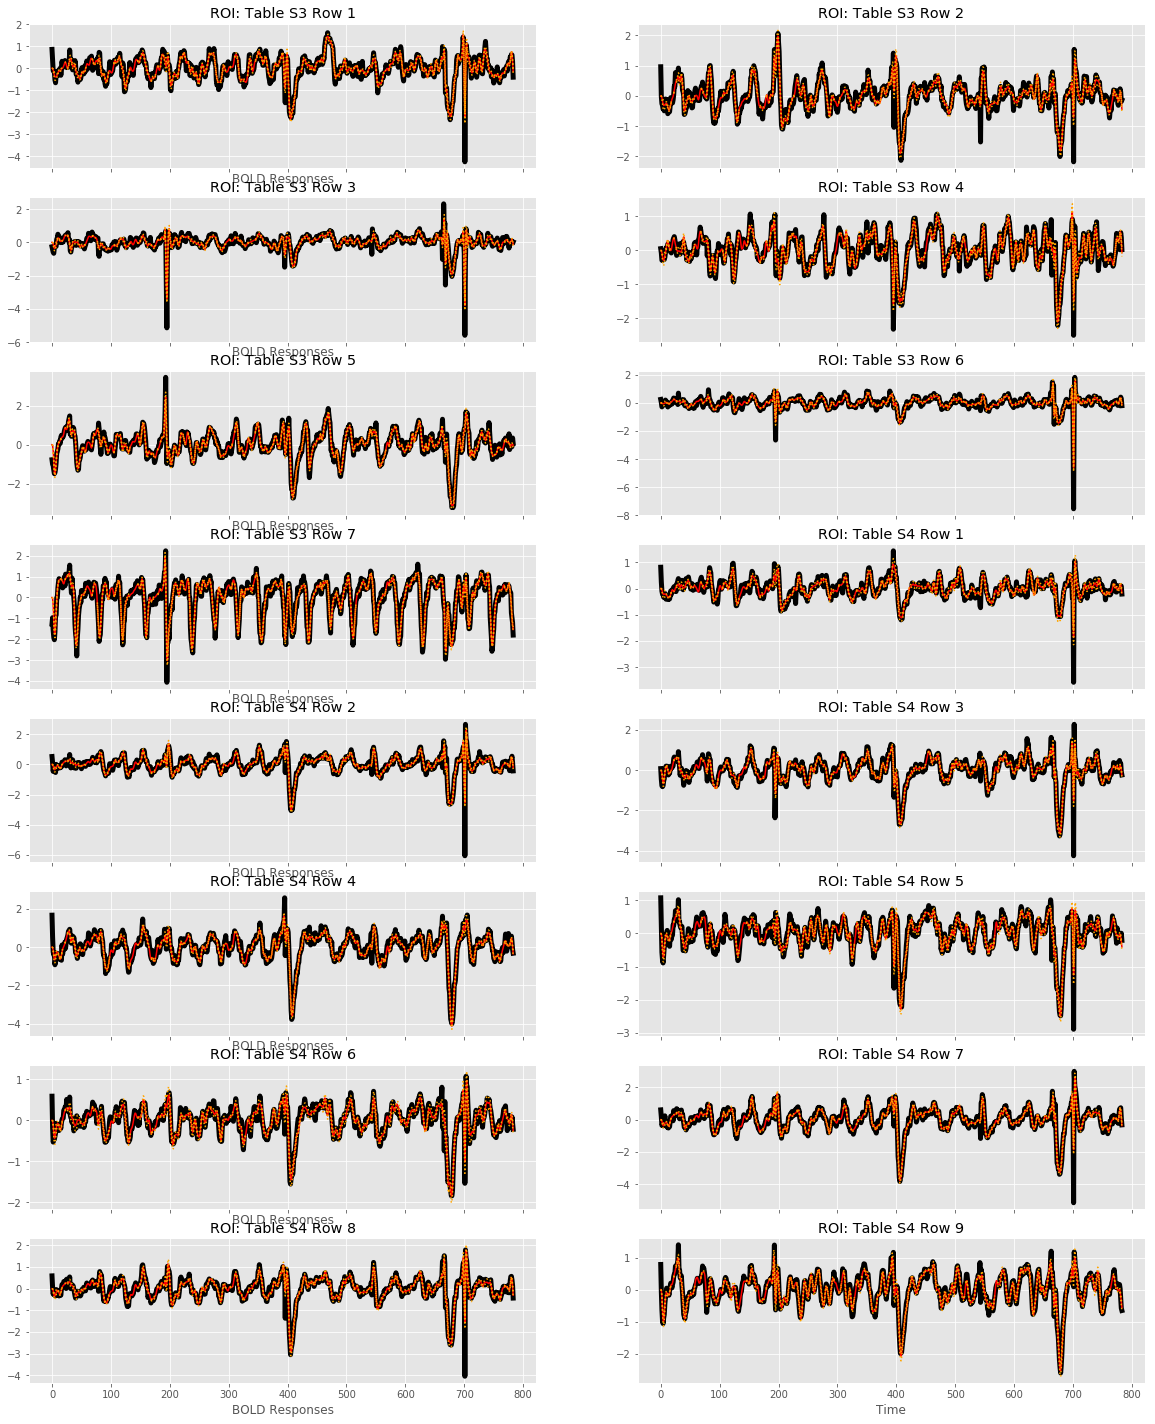

In [26]:
fig, axs = plt.subplots(8, 2, figsize=(20, 25), sharex=True)
for r in range(8):
    for c in range(2):
        voxel_idx = c+r*2
        if voxel_idx < 16:
            axs[r,c].plot(ts_sparse, Y_N1[:,voxel_idx], c="k", label="Data", linewidth=5)
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx], c="r", label = "Mean prediction")
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx] - 1.96 * yhat_sd, c="orange",linestyle=":", label="95% predictive interval")
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx] + 1.96 * yhat_sd, c="orange",linestyle=":")
            axs[r,c].set_title("ROI: "+label_ROI[voxel_idx])
        if r == 7:
            axs[r,c].set_xlabel("Time")
        if c==0:
            axs[r,c].set_xlabel("BOLD Responses")

## Recovery: Behavioral Data

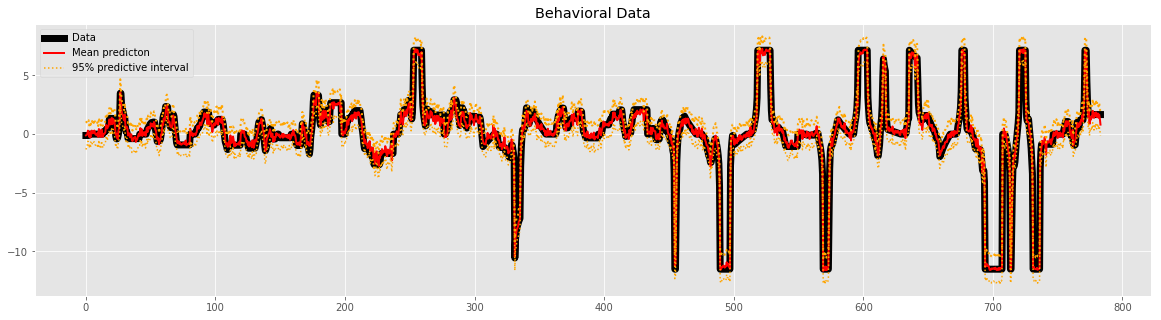

In [27]:
bmean, bV, bci = recover_behavioral(test, ts_dense)

plt.figure(figsize=(20,5))
plt.plot(ts_dense, Y_B1.ravel(), c="k", linewidth = 7, label="Data")
plt.plot(ts_dense, bmean.ravel(), c="r", label = "Mean predicton", linewidth=2)
plt.plot(ts_dense, bci[:,0], c="orange", linestyle = ":", label="95% predictive interval")
plt.plot(ts_dense, bci[:,1], c="orange", linestyle = ":", linewidth=2)
# plt.plot(bhat3, label = "3-dim")

plt.legend()
plt.title("Behavioral Data")
plt.show()

## Estimated Latent Dynamics

Text(0.5,1,'Latent Dynamics: The three-dimensional space')

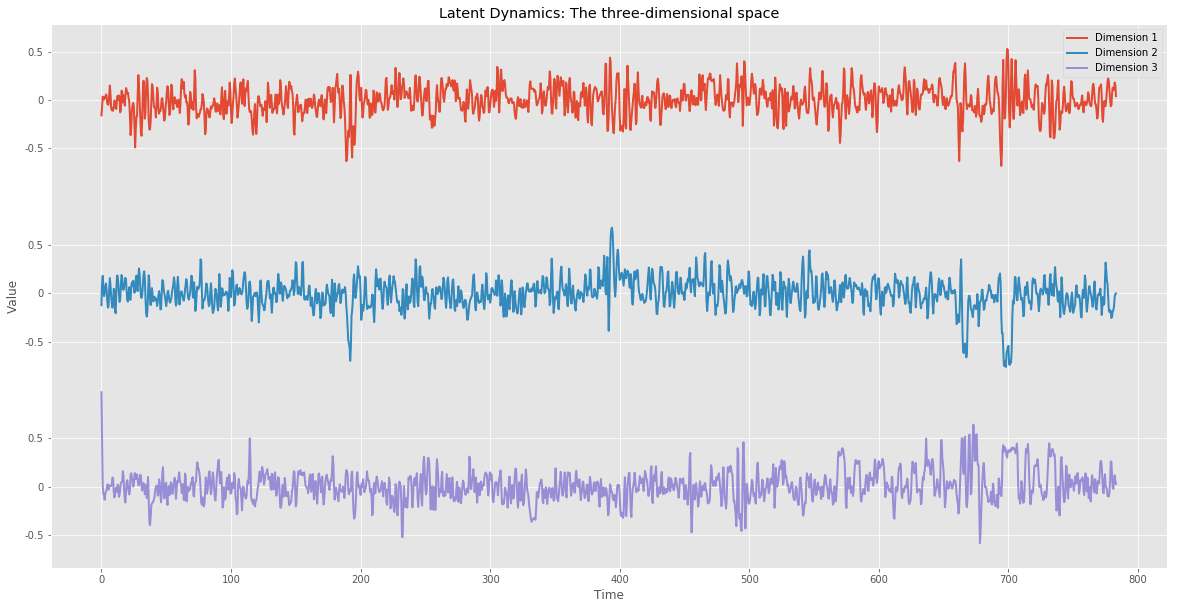

In [28]:
plt.figure(figsize=(20,10))
plt.plot(ts_dense, test.X.value[:,0]+3, label = "Dimension 1", linewidth=2)
plt.plot(ts_dense, test.X.value[:,1]+1, label = "Dimension 2", linewidth=2)
plt.plot(ts_dense, test.X.value[:,2]-1, label = "Dimension 3", linewidth=2)
plt.yticks([-1.5, -1, -0.5, 0.5, 1, 1.5, 2.5, 3, 3.5], [-.5, 0, .5, -.5, 0, .5, -.5, 0, .5])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Latent Dynamics: The three-dimensional space")